# __Longitudinal Inference of Multiscale Markers of Psychosis__
# _- From Hippocampal Centrality to Functional Outcome_
### Totzek, J. F., Chakravarty, M. M., Joober, R., Malla, A., Shah, J., Young, A. L., Hernaus, D., Lepage, M. & Lavigne, K. M. (accepted). _Molecular Psychiatry_

This notebook describes the processing steps that were performed for the z-score Subtype and Stage Inference (z-score SuStaIn, [Young et al. (2018)](https://doi.org/10.1038/s41467-018-05892-0
)) analysis of the article "Longitudinal Inference of Multiscale Markers of Psychosis - From Hippocampal Centraliy to Functional Outcome" (Totzek et al., accepted). Analyses were performed by the means of pySuStaIn [Aksman et al. (2021)](https://doi.org/10.1016/j.softx.2021.100811).

The notebook was replicated from the open-source SuStaIn workshop on GitHub: [pySuStaIn Workshop](https://github.com/ucl-pond/pySuStaIn/blob/master/notebooks/SuStaInWorkshop.ipynb
) and adapted to the variables of our dataset. The link to the overall pySuStaIn GitHub repository can be found [here](https://github.com/ucl-pond/pySuStaIn). 

In [ ]:
# Load libraries

import os
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

The input .csv frame has the dimensions 280 (participants) x 11 (variables). 

The 11 variables include: 
- subject ID
- group
- age
- sex
- total brain volume (TBV)
- left hippocampal centrality (HC_L)
- right hippocampal centrality (HC_R)
- episodic memory (verbal memory)
- social cognition
- negative symptoms
- functional outcome 

The variables of bilateral hippocampal centrality, episodic memory, social cognition, negative symptoms and functional outcome are the 6 biomarkers on which we performed z-score SuStaIn. We further controlled for age, sex, and TBV.

In [ ]:
# load dataset 
np.random.seed(0)
data = pandas.read_excel('/Users/jana/multiscale_markers/input_sustain_multiscale_markers.xlsx')
data.Group.value_counts()

In [ ]:
#store biomarkers labels as variables

biomarkers = data.columns[1:7]
print(biomarkers)

In [ ]:
# first a quick look at the patient and control distribution for one of our biomarkers

biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='Group', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

In [ ]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

As negative symptoms and functional outcome did not have control values in our dataset, we z-scored the patient data relative to control means and standard deviations as reported by [Oruç et al. (2017)](https://doi.org/10.4103/1119-3077.212453) for negative symmptoms and by [Agid et al. (2018)](https://doi.org/10.1016/j.schres.2012.07.012) for functional outcome. We then performed the regression relative to the patient sample itself. The other biomarkers were z-scored relative to the control group. 


In [ ]:
# for each biomarker
for biomarker in biomarkers:
    if biomarker=='Neg_Symp_z' or biomarker=='Func_Out_z':
        mod = smf.ols('%s ~ Age + Sex + TBV'%biomarker,  # fit a model finding the effect of age, sex, and TBV on biomarker
                  data=data[data.Group==1] # fit this model *only* to individuals in the patient group
                 ).fit() # fit model
    else:
        mod = smf.ols('%s ~ Age + Sex + TBV'%biomarker,  # fit a model finding the effect of age, sex, and TBV on biomarker
                  data=data[data.Group==4] # fit this model *only* to individuals in the control group
                 ).fit() # fit model
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['Age','Sex', 'TBV',biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals

    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==4]))
    #print(np.std(w_score[data.Diagnosis==4]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score

In [ ]:
zdata_patients = zdata[zdata.Group==1]
zdata_controls = zdata[zdata.Group==4]

In [ ]:
IS_decreasing = np.mean(zdata,axis=0)<np.mean(zdata_controls,axis=0)
IS_decreasing

For the analyses, all biomarker values need to increase with disease progression. We therefore need to identify those who do not, which will have mean_data < mean_control. We typically expect for markers (except symptoms) to have a smaller mean in patients than controls. 
Those biomarkers then need to be multiplied by -1 (see [pySuStaIn Simulated Data](https://github.com/ucl-pond/pySuStaIn/blob/master/notebooks/SuStaIn%20tutorial%20using%20simulated%20data.ipynb)).

In our case, right hippocampal centrality is slightly higher in patients than controls, yet we hypothesize for this variable to decrease with continuing disease progression. For those reasons we reverse all markers except negative symptoms, as we except for those to increase with continuing disease progression. 

In [ ]:
zdata.L_Hippo *= -1
zdata.R_Hippo *= -1
zdata.Episodic_Mem *= -1
zdata.Social_Cog *= -1
zdata.Func_Out_z *= -1

In [ ]:
#we need to label the variable again according to the reversed zdata

zdata_patients = zdata[zdata.Group==1]
zdata_controls = zdata[zdata.Group==4]

In [ ]:
IS_decreasing = np.mean(zdata,axis=0)<np.mean(zdata_controls,axis=0)
IS_decreasing

In [ ]:
# Check that the mean of the control population is 0
print('Mean of controls is ',np.mean(zdata[zdata.Group==4],axis=0))
# Check that the standard deviation of the control population is 1
print('Standard deviation of controls is ',np.std(zdata[zdata.Group==4],axis=0))
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(zdata,axis=0))
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(zdata,axis=0))

In [ ]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
biomarker = biomarkers[1]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
biomarker = biomarkers[2]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
biomarker = biomarkers[3]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
biomarker = biomarkers[4]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
biomarker = biomarkers[5]
sns.displot(data=zdata,x=biomarker,hue='Group',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [ ]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [ ]:
print(Z_vals)
print(Z_vals.shape)

As the data of our control group misses data for functional outcome and negative symptoms, we cannot perform z-score SuStaIn on the full sample. Hence, we only perform the analysis on the patient population: zdata_patients[biomarkers].

In [ ]:
# Input the settings for z-score SuStaIn

N_startpoints = 25
N_S_max = 2
N_iterations_MCMC = int(1e6)
output_folder = os.path.join(os.getcwd(), 'output_multiscale_markers')
dataset_name = 'output_multiscale_markers'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata_patients[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              True)

In [ ]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [ ]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

In [ ]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

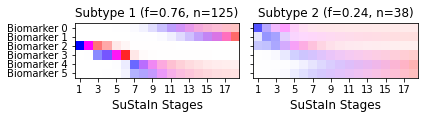

In [25]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata_patients) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M, subtype_order=(0,1))

In [ ]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

In [ ]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata_patients.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata_patients.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

In [ ]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata_patients.loc[:,'ml_subtype'] = zdata_patients.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata_patients.loc[zdata_patients.ml_stage==0,'ml_subtype'] = 0

In [ ]:
zdata_patients.ml_subtype.value_counts()

In [ ]:
zdata_patients.to_excel('/Users/jana/multiscale_markers/Multiscale_Markers_Output.xlsx')

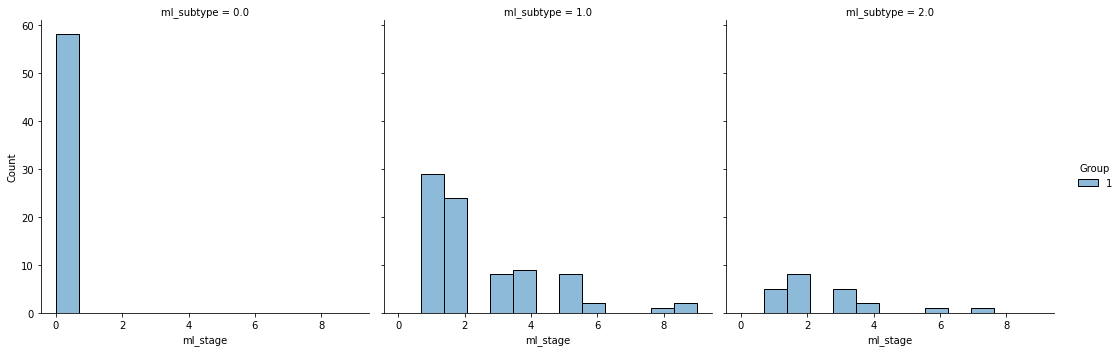

In [31]:
sns.displot(x='ml_stage',hue='Group',data=zdata_patients,col='ml_subtype')

In [ ]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata_patients[zdata_patients.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

In [ ]:
#CROSS-VALIDATION 
N_folds = 10

# generate stratified cross-validation training and test set splits
labels = zdata_patients.Group.values
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it = cv.split(zdata_patients, labels)

test_idxs = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs = np.array(test_idxs,dtype='object')

In [ ]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

CVIC for each subtype model: [3326.73492386 3329.44384496]
Average test set log-likelihood for each subtype model: [-168.08498314 -168.32361186]


Text(0.5, 1.0, 'Test set log-likelihood across folds')

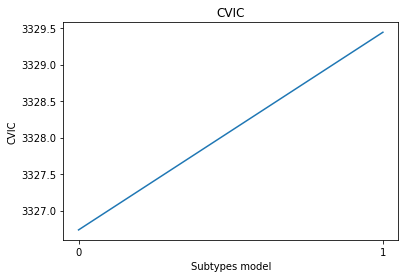

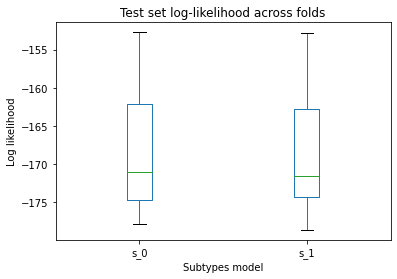

In [35]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

plt.figure(0)    
plt.plot(np.arange(N_S_max,dtype=int),CVIC)
plt.xticks(np.arange(N_S_max,dtype=int))
plt.ylabel('CVIC')  
plt.xlabel('Subtypes model') 
plt.title('CVIC')

plt.figure(1)
df_loglike = pandas.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
plt.ylabel('Log likelihood')  
plt.xlabel('Subtypes model') 
plt.title('Test set log-likelihood across folds')

/Users/jana/opt/anaconda3/lib/python3.9/site-packages/pySuStaIn/ZscoreSustain.py:507: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
/Users/jana/opt/anaconda3/lib/python3.9/site-packages/pySuStaIn/AbstractSustain.py:522: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


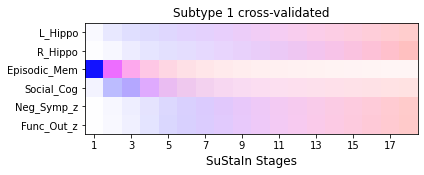

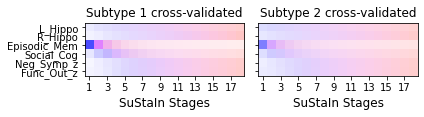

In [36]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max):
    sustain_input.combine_cross_validated_sequences(i+1, N_folds)

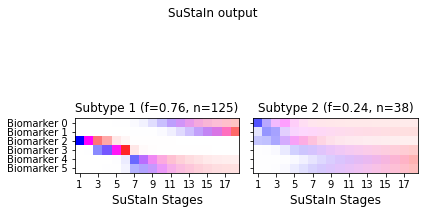

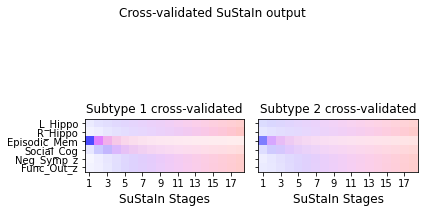

In [37]:
N_S_selected = 2

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))
_ = plt.suptitle('SuStaIn output')

sustain_input.combine_cross_validated_sequences(N_S_selected, N_folds)
_ = plt.suptitle('Cross-validated SuStaIn output')